Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def decorrelate(num_epochs, data, model, decor_lr):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()
        model.weight -= decor_lr * model.weight.grad
        print(f'iteration {i}\tloss: {L[i]:.3f}')

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

In [5]:
num_samples=1000
num_features=100
num_epochs=2000
seed=42
decor_lr=1e1
eta=1e-2 # NOTE: eta -> 0: normalize; eta > 0: decorrelate

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,)).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, bias=False, eta=eta, whiten=True).to(device) # variance can be None (no variance contraint) or 'input or 1.0 or (d1,...,dn)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr)


iteration 0	loss: 0.064
iteration 1	loss: 0.056
iteration 2	loss: 0.049
iteration 3	loss: 0.044
iteration 4	loss: 0.040
iteration 5	loss: 0.037
iteration 6	loss: 0.034
iteration 7	loss: 0.031
iteration 8	loss: 0.029
iteration 9	loss: 0.028
iteration 10	loss: 0.026
iteration 11	loss: 0.025
iteration 12	loss: 0.024
iteration 13	loss: 0.023
iteration 14	loss: 0.022
iteration 15	loss: 0.021
iteration 16	loss: 0.020
iteration 17	loss: 0.019
iteration 18	loss: 0.019
iteration 19	loss: 0.018
iteration 20	loss: 0.018
iteration 21	loss: 0.017
iteration 22	loss: 0.017
iteration 23	loss: 0.017
iteration 24	loss: 0.016
iteration 25	loss: 0.016
iteration 26	loss: 0.016
iteration 27	loss: 0.015
iteration 28	loss: 0.015
iteration 29	loss: 0.015
iteration 30	loss: 0.014
iteration 31	loss: 0.014
iteration 32	loss: 0.014
iteration 33	loss: 0.014
iteration 34	loss: 0.014
iteration 35	loss: 0.013
iteration 36	loss: 0.013
iteration 37	loss: 0.013
iteration 38	loss: 0.013
iteration 39	loss: 0.013
iteration 

mean variance: 0.50


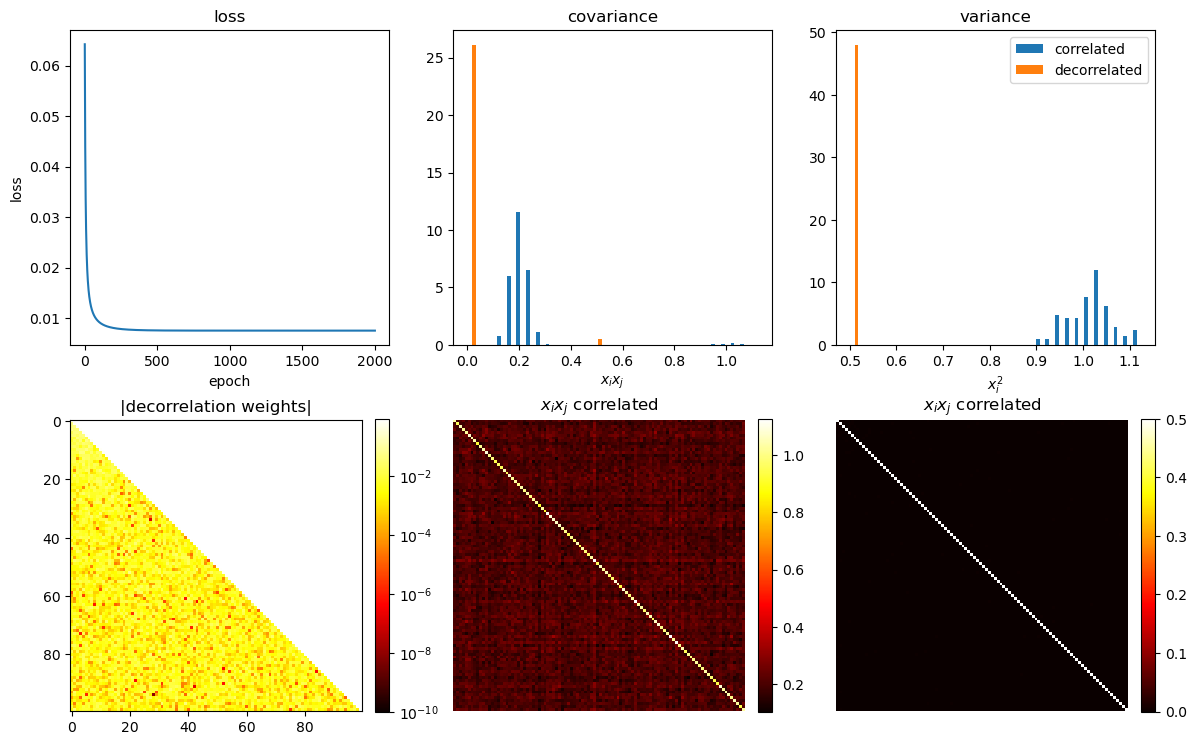

In [6]:
plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')

Decorrelation of correlated input using DecorConv2d

In [7]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=1000
seed=42
decor_lr=1e-1
eta=1e-2
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width).to(device)

# create a convolutional decorrelator
# NOTE: how many samples for effective input decorrelation? Dependence on dim?
# nr of samples instead of perc?
# NOTE: version for immediate non-batched decorrelation...
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False, eta=eta, whiten=True, downsample_perc=downsample_perc).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr) 


iteration 0	loss: 1.083
iteration 1	loss: 0.697
iteration 2	loss: 0.665
iteration 3	loss: 0.759
iteration 4	loss: 0.465
iteration 5	loss: 0.686
iteration 6	loss: 0.428
iteration 7	loss: 0.601
iteration 8	loss: 0.843
iteration 9	loss: 0.540
iteration 10	loss: 0.579
iteration 11	loss: 0.504
iteration 12	loss: 0.432
iteration 13	loss: 0.414
iteration 14	loss: 0.519
iteration 15	loss: 0.433
iteration 16	loss: 0.605
iteration 17	loss: 0.422
iteration 18	loss: 0.492
iteration 19	loss: 0.376
iteration 20	loss: 0.499
iteration 21	loss: 0.309
iteration 22	loss: 0.372
iteration 23	loss: 0.666
iteration 24	loss: 0.355
iteration 25	loss: 0.450
iteration 26	loss: 0.229
iteration 27	loss: 0.367
iteration 28	loss: 0.377
iteration 29	loss: 0.226
iteration 30	loss: 0.365
iteration 31	loss: 0.348
iteration 32	loss: 0.377
iteration 33	loss: 0.255
iteration 34	loss: 0.362
iteration 35	loss: 0.187
iteration 36	loss: 0.354
iteration 37	loss: 0.244
iteration 38	loss: 0.370
iteration 39	loss: 0.248
iteration 

mean variance: 0.13


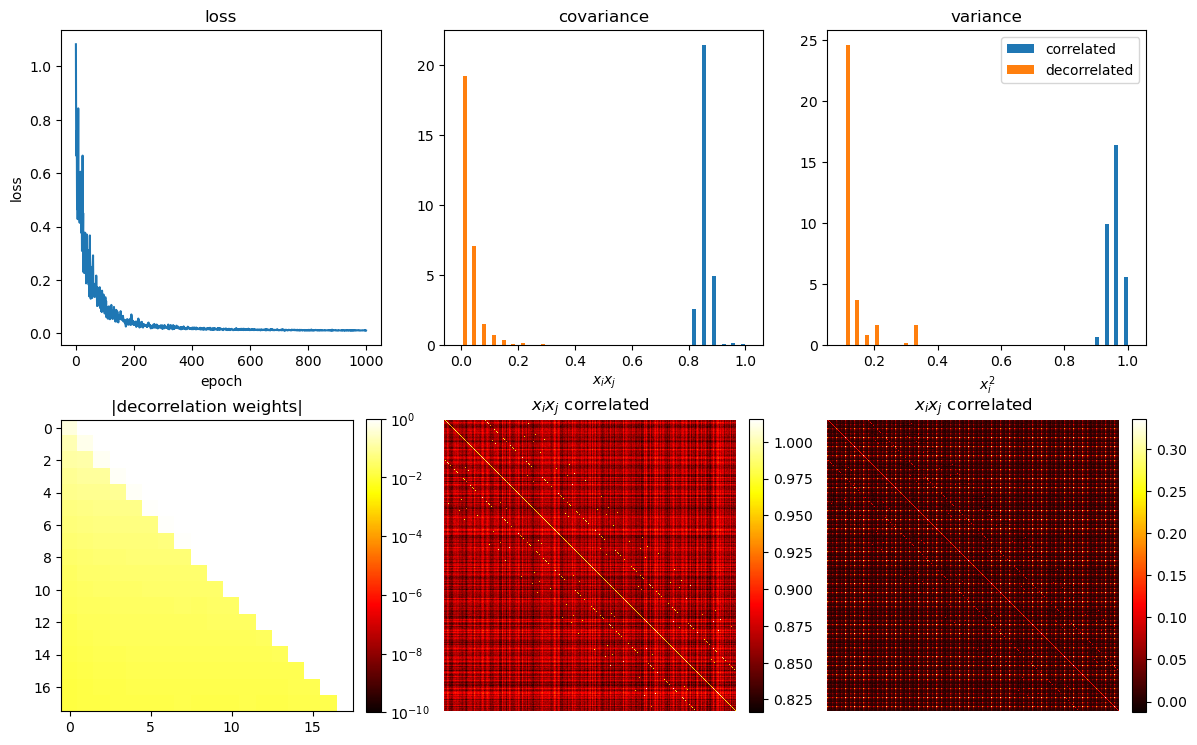

In [8]:
plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')

In [9]:
# fig, ax = plt.subplots(2,3, figsize=(14, 9))
# plot_loss(ax[0,0], L)
# covariance_histogram(ax[0,1], A1, A2)
# variance_histogram(ax[0,2], A1, A2, labels=['correlated', 'decorrelated'])
# plot_decorrelation_matrix(ax[1,0], model.weight)
# plot_covariance_matrix(ax[1,1], A1)
# plot_covariance_matrix(ax[1,2], A2)